In [2]:
import pandas as pd
import os
from datetime import datetime

print("Memuat semua file CSV...")

# Daftar file yang akan dimuat
files_to_load = {
    "customers": "olist_customers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "payments": "olist_order_payments_dataset.csv",
    "reviews": "olist_order_reviews_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "products": "olist_products_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "translation": "product_category_name_translation.csv"
}

# Dictionary untuk menyimpan semua DataFrame
dfs = {}
semua_file_ada = True

try:
    for name, file_name in files_to_load.items():
        if os.path.exists(file_name):
            dfs[name] = pd.read_csv(file_name)
            print(f"File '{file_name}' (dfs['{name}']) berhasil dimuat.")
        else:
            print(f"!!! ERROR: File '{file_name}' tidak ditemukan. Harap unggah file ini.")
            semua_file_ada = False

    if semua_file_ada:
        print("\nSemua file CSV berhasil dimuat ke DataFrame Pandas.")
    else:
        print("\nBeberapa file tidak ditemukan. Proses mungkin gagal di langkah selanjutnya.")

except Exception as e:
    print(f"Terjadi error saat memuat file: {e}")

Memuat semua file CSV...
File 'olist_customers_dataset.csv' (dfs['customers']) berhasil dimuat.
File 'olist_geolocation_dataset.csv' (dfs['geolocation']) berhasil dimuat.
File 'olist_order_items_dataset.csv' (dfs['order_items']) berhasil dimuat.
File 'olist_order_payments_dataset.csv' (dfs['payments']) berhasil dimuat.
File 'olist_order_reviews_dataset.csv' (dfs['reviews']) berhasil dimuat.
File 'olist_orders_dataset.csv' (dfs['orders']) berhasil dimuat.
File 'olist_products_dataset.csv' (dfs['products']) berhasil dimuat.
File 'olist_sellers_dataset.csv' (dfs['sellers']) berhasil dimuat.
File 'product_category_name_translation.csv' (dfs['translation']) berhasil dimuat.

Semua file CSV berhasil dimuat ke DataFrame Pandas.


In [3]:
if semua_file_ada:
    print("\n--- Memulai Proses Transformasi (T) ---")

    try:
        # --- T1: Membuat Tabel Dimensi ---

        print("Membuat dim_customer...")
        dim_customer = dfs['customers'][[
            "customer_id",
            "customer_unique_id",
            "customer_zip_code_prefix",
            "customer_city",
            "customer_state"
        ]].drop_duplicates().reset_index(drop=True)

        print("Membuat dim_product (dengan translasi kategori)...")
        products_translated = pd.merge(
            dfs['products'],
            dfs['translation'],
            on="product_category_name",
            how="left"
        )
        dim_product = products_translated[[
            "product_id",
            "product_category_name_english",
            "product_name_lenght", # Nama kolom di file Anda mungkin 'lenght'
            "product_description_lenght", # Nama kolom di file Anda mungkin 'lenght'
            "product_photos_qty",
            "product_weight_g",
            "product_length_cm",
            "product_height_cm",
            "product_width_cm"
        ]].rename(columns={
            "product_category_name_english": "product_category",
            "product_name_lenght": "product_name_length",
            "product_description_lenght": "product_description_length"
        }).drop_duplicates().reset_index(drop=True)

        print("Membuat dim_seller...")
        dim_seller = dfs['sellers'][[
            "seller_id",
            "seller_zip_code_prefix",
            "seller_city",
            "seller_state"
        ]].drop_duplicates().reset_index(drop=True)

        print("Membuat dim_date...")
        orders_df = dfs['orders'].copy()
        orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])

        unique_dates = orders_df['order_purchase_timestamp'].dt.normalize().unique()
        dim_date = pd.DataFrame({'date_key': unique_dates})
        dim_date = dim_date.dropna()

        dim_date['full_date'] = dim_date['date_key']
        dim_date['day_of_week'] = dim_date['date_key'].dt.dayofweek
        dim_date['day_name'] = dim_date['date_key'].dt.day_name()
        dim_date['day_of_month'] = dim_date['date_key'].dt.day
        dim_date['day_of_year'] = dim_date['date_key'].dt.dayofyear
        dim_date['month'] = dim_date['date_key'].dt.month
        dim_date['month_name'] = dim_date['date_key'].dt.month_name()
        dim_date['quarter'] = dim_date['date_key'].dt.quarter
        dim_date['year'] = dim_date['date_key'].dt.year
        dim_date['is_weekend'] = dim_date['day_of_week'].isin([5, 6])
        # Ubah date_key menjadi string YYYY-MM-DD agar mudah untuk di-join
        dim_date['date_key'] = dim_date['date_key'].dt.strftime('%Y-%m-%d')

        # --- T2: Membuat Fact Table (Membutuhkan JOIN) ---
        print("Membuat fact_sales...")

        agg_payments = dfs['payments'].groupby('order_id')['payment_value'].sum().reset_index()
        agg_reviews = dfs['reviews'].groupby('order_id')['review_score'].mean().reset_index()

        fact_sales = pd.merge(dfs['order_items'], orders_df, on='order_id', how='left')
        fact_sales = pd.merge(fact_sales, dim_customer, on='customer_id', how='left')
        fact_sales = pd.merge(fact_sales, agg_payments, on='order_id', how='left')
        fact_sales = pd.merge(fact_sales, agg_reviews, on='order_id', how='left')

        fact_sales['order_purchase_timestamp'] = pd.to_datetime(fact_sales['order_purchase_timestamp'])
        fact_sales['order_delivered_customer_date'] = pd.to_datetime(fact_sales['order_delivered_customer_date'])

        fact_sales['order_purchase_date_key'] = fact_sales['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')
        fact_sales['order_delivered_date_key'] = fact_sales['order_delivered_customer_date'].dt.strftime('%Y-%m-%d')

        fact_sales = fact_sales[[
            "order_id",
            "order_item_id",
            "product_id",
            "seller_id",
            "customer_id",
            "order_purchase_date_key",
            "order_delivered_date_key",
            "price",
            "freight_value",
            "payment_value",
            "review_score",
            "order_status"
        ]].reset_index(drop=True)

        print("--- Transformasi Selesai ---")
        print("\nContoh data fact_sales:")
        print(fact_sales.head())

    except Exception as e:
        print(f"Terjadi error saat transformasi data: {e}")
else:
    print("Proses Transformasi dibatalkan karena tidak semua file dimuat.")


--- Memulai Proses Transformasi (T) ---
Membuat dim_customer...
Membuat dim_product (dengan translasi kategori)...
Membuat dim_seller...
Membuat dim_date...
Membuat fact_sales...
--- Transformasi Selesai ---

Contoh data fact_sales:
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  

In [4]:
if semua_file_ada:
    print("\n--- Memulai Proses Load (L) ---")

    # Tentukan nama file output
    output_files = {
        "dim_customer": "dim_customer_output.csv",
        "dim_product": "dim_product_output.csv",
        "dim_seller": "dim_seller_output.csv",
        "dim_date": "dim_date_output.csv",
        "fact_sales": "fact_sales_output.csv"
    }

    try:
        dim_customer.to_csv(output_files["dim_customer"], index=False)
        dim_product.to_csv(output_files["dim_product"], index=False)
        dim_seller.to_csv(output_files["dim_seller"], index=False)
        dim_date.to_csv(output_files["dim_date"], index=False)
        fact_sales.to_csv(output_files["fact_sales"], index=False)

        print(f"Data Warehouse Anda berhasil disimpan sebagai file CSV:")
        for name, path in output_files.items():
            print(f"- {name} disimpan sebagai {path}")

    except Exception as e:
        print(f"Gagal menyimpan file CSV: {e}")
else:
    print("Proses Load dibatalkan.")


--- Memulai Proses Load (L) ---
Data Warehouse Anda berhasil disimpan sebagai file CSV:
- dim_customer disimpan sebagai dim_customer_output.csv
- dim_product disimpan sebagai dim_product_output.csv
- dim_seller disimpan sebagai dim_seller_output.csv
- dim_date disimpan sebagai dim_date_output.csv
- fact_sales disimpan sebagai fact_sales_output.csv


In [5]:
if semua_file_ada:
    print("\n--- Memulai Proses Analisis ---")

    try:
        # 1. Membuat "Analytics View"
        # Kita gabungkan (join) tabel fakta dan dimensi untuk mempermudah analisis
        print("Membuat 'Analytics View' (v_sales_report_df)...")

        v_sales_report_df = pd.merge(
            fact_sales,
            dim_date,
            left_on='order_purchase_date_key',
            right_on='date_key',
            how='left'
        )
        v_sales_report_df = pd.merge(
            v_sales_report_df,
            dim_product,
            on='product_id',
            how='left'
        )
        v_sales_report_df = pd.merge(
            v_sales_report_df,
            dim_customer,
            on='customer_id',
            how='left'
        )

        print("Contoh data 'Analytics View':")
        print(v_sales_report_df[['order_id', 'full_date', 'product_category', 'customer_city', 'payment_value']].head())


        # 2. KPI: Revenue per Bulan
        print("\n--- KPI: Total Revenue per Bulan ---")
        revenue_by_month = v_sales_report_df.groupby(['year', 'month_name'])['payment_value'].sum().reset_index()
        # Urutkan berdasarkan tahun dan bulan (membutuhkan konversi bulan)
        revenue_by_month['month_num'] = pd.to_datetime(revenue_by_month['month_name'], format='%B').dt.month
        revenue_by_month = revenue_by_month.sort_values(by=['year', 'month_num'])
        print(revenue_by_month[['year', 'month_name', 'payment_value']])


        # 3. Product Insights: Top 10 Kategori
        print("\n--- Product Insights: Top 10 Kategori ---")
        top_categories = v_sales_report_df.groupby('product_category').agg(
            total_revenue=('payment_value', 'sum'),
            average_review=('review_score', 'mean')
        ).reset_index()
        top_categories = top_categories.sort_values(by='total_revenue', ascending=False)
        print(top_categories.head(10))


        # 4. Geospatial Analysis: Sales by Region (State)
        print("\n--- Geospatial Analysis: Sales by State ---")
        sales_by_state = v_sales_report_df.groupby('customer_state').agg(
            total_orders=('order_id', 'nunique'),
            total_sales=('payment_value', 'sum')
        ).reset_index()
        sales_by_state = sales_by_state.sort_values(by='total_sales', ascending=False)
        print(sales_by_state.head(10))


        # 5. Customer Segmentation (Data untuk RFM Analysis)
        print("\n--- Customer Segmentation: Data RFM ---")

        # Kita perlu 'customer_unique_id'
        rfm_base = pd.merge(fact_sales, dim_customer, on='customer_id', how='left')
        rfm_base['order_purchase_date'] = pd.to_datetime(rfm_base['order_purchase_date_key'])

        # Tentukan tanggal "hari ini" (kita gunakan 1 hari setelah tanggal max di dataset)
        today = rfm_base['order_purchase_date'].max() + pd.Timedelta(days=1)

        rfm_analysis = rfm_base.groupby('customer_unique_id').agg(
            Recency=('order_purchase_date', lambda x: (today - x.max()).days),
            Frequency=('order_id', 'nunique'),
            Monetary=('payment_value', 'sum')
        ).reset_index()

        print("Contoh data RFM (Recency, Frequency, Monetary):")
        print(rfm_analysis.head())

    except Exception as e:
        print(f"Terjadi error saat analisis: {e}")
else:
    print("Proses Analisis dibatalkan.")


--- Memulai Proses Analisis ---
Membuat 'Analytics View' (v_sales_report_df)...
Contoh data 'Analytics View':
                           order_id  full_date product_category  \
0  00010242fe8c5a6d1ba2dd792cb16214 2017-09-13       cool_stuff   
1  00018f77f2f0320c557190d7a144bdd3 2017-04-26         pet_shop   
2  000229ec398224ef6ca0657da4fc703e 2018-01-14  furniture_decor   
3  00024acbcdf0a6daa1e931b038114c75 2018-08-08        perfumery   
4  00042b26cf59d7ce69dfabb4e55b4fd9 2017-02-04     garden_tools   

           customer_city  payment_value  
0  campos dos goytacazes          72.19  
1        santa fe do sul         259.83  
2          para de minas         216.87  
3                atibaia          25.78  
4        varzea paulista         218.04  

--- KPI: Total Revenue per Bulan ---
    year month_name  payment_value
2   2016  September         347.52
1   2016    October       73914.58
0   2016   December          19.62
7   2017    January      187779.41
6   2017   February  

In [6]:
try:
    # Nama file ini adalah data yang siap untuk divisualisasikan
    dashboard_file_name = "sales_dashboard_data.csv"

    # Pilih kolom yang relevan saja untuk dasbor
    # Ini membuat file lebih kecil dan lebih cepat di Looker Studio
    dashboard_columns = [
        'order_id', 'payment_value', 'freight_value', 'review_score',
        'full_date', 'month_name', 'year', 'day_name',
        'product_category',
        'customer_city', 'customer_state'
    ]

    v_sales_report_df[dashboard_columns].to_csv(dashboard_file_name, index=False)

    print(f"\nBerhasil! File '{dashboard_file_name}' siap diunduh.")
    print("File ini berisi semua data gabungan yang Anda perlukan untuk Looker Studio.")

except Exception as e:
    print(f"Error saat menyimpan file dasbor: {e}")


Berhasil! File 'sales_dashboard_data.csv' siap diunduh.
File ini berisi semua data gabungan yang Anda perlukan untuk Looker Studio.


Visualisasi


Memulai visualisasi di Colab...
Membuat plot 'Tren Revenue Bulanan'...


/tmp/ipython-input-788358808.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = v_sales_report_df.set_index('full_date').resample('M')['payment_value'].sum().reset_index()


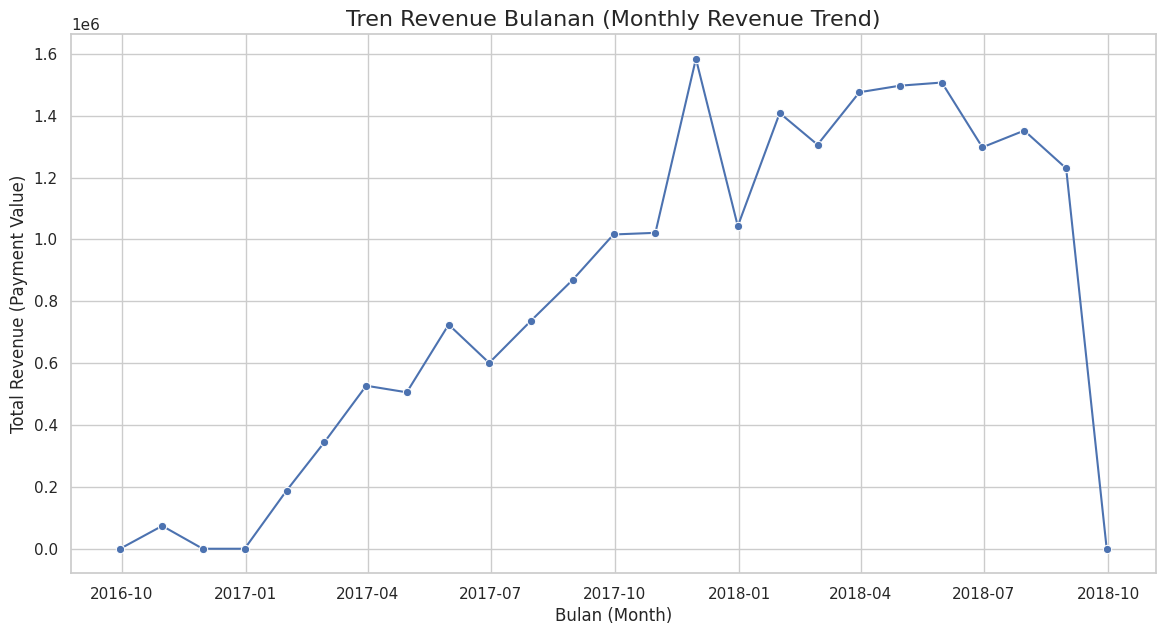

Membuat plot 'Top 10 Kategori Produk'...


/tmp/ipython-input-788358808.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, y='product_category', x='payment_value', orient='h', palette='viridis')


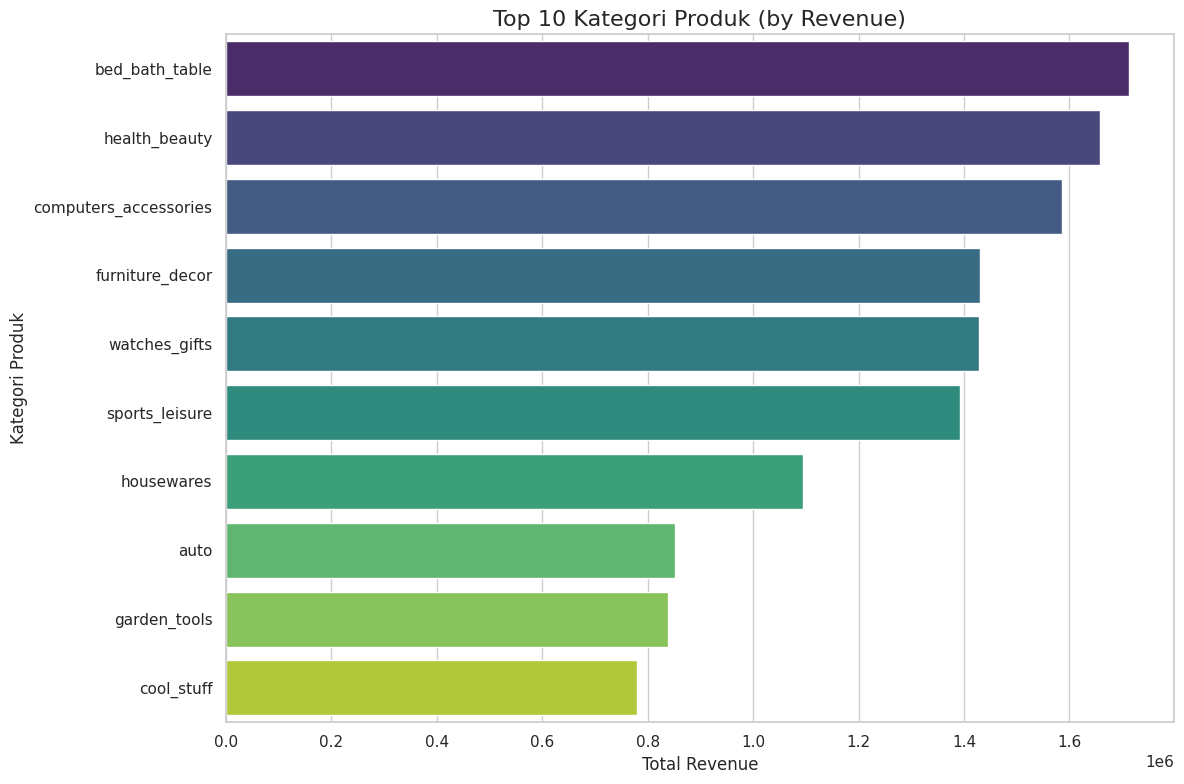

Membuat plot 'Top 10 Penjualan per Negara Bagian'...


/tmp/ipython-input-788358808.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_state, y='customer_state', x='payment_value', orient='h', palette='plasma')


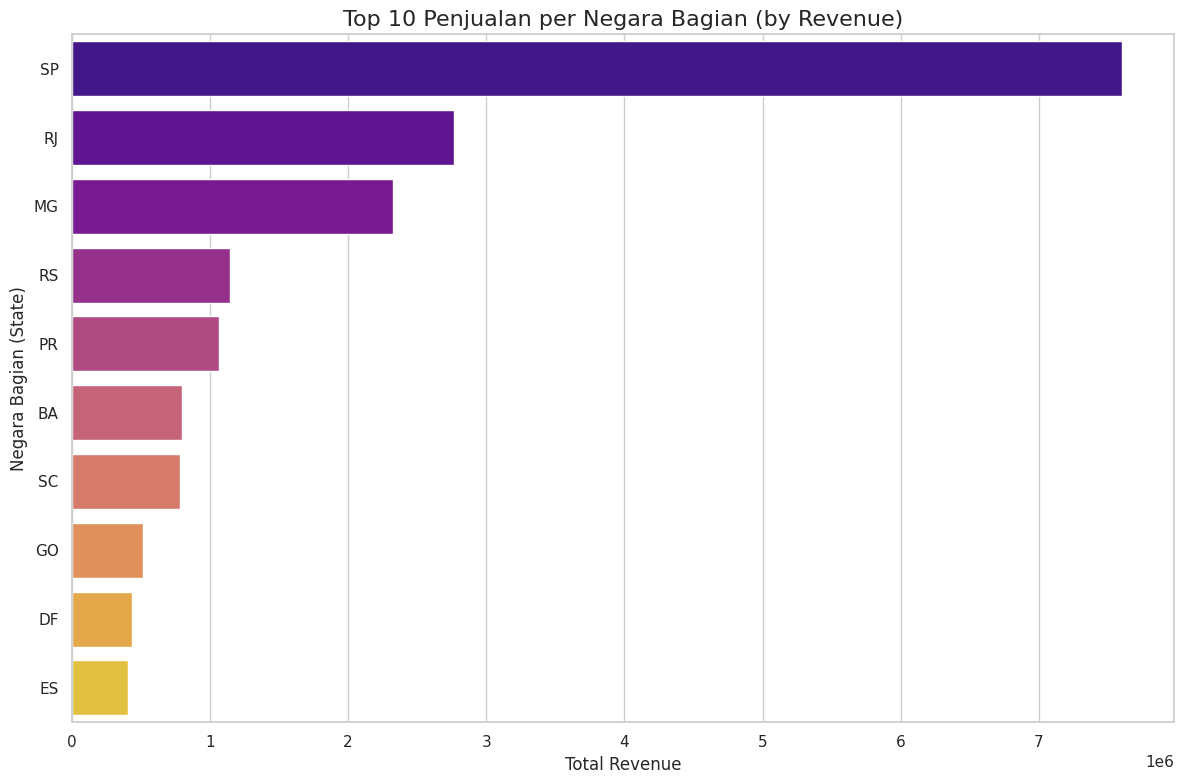

Membuat plot 'Distribusi RFM'...


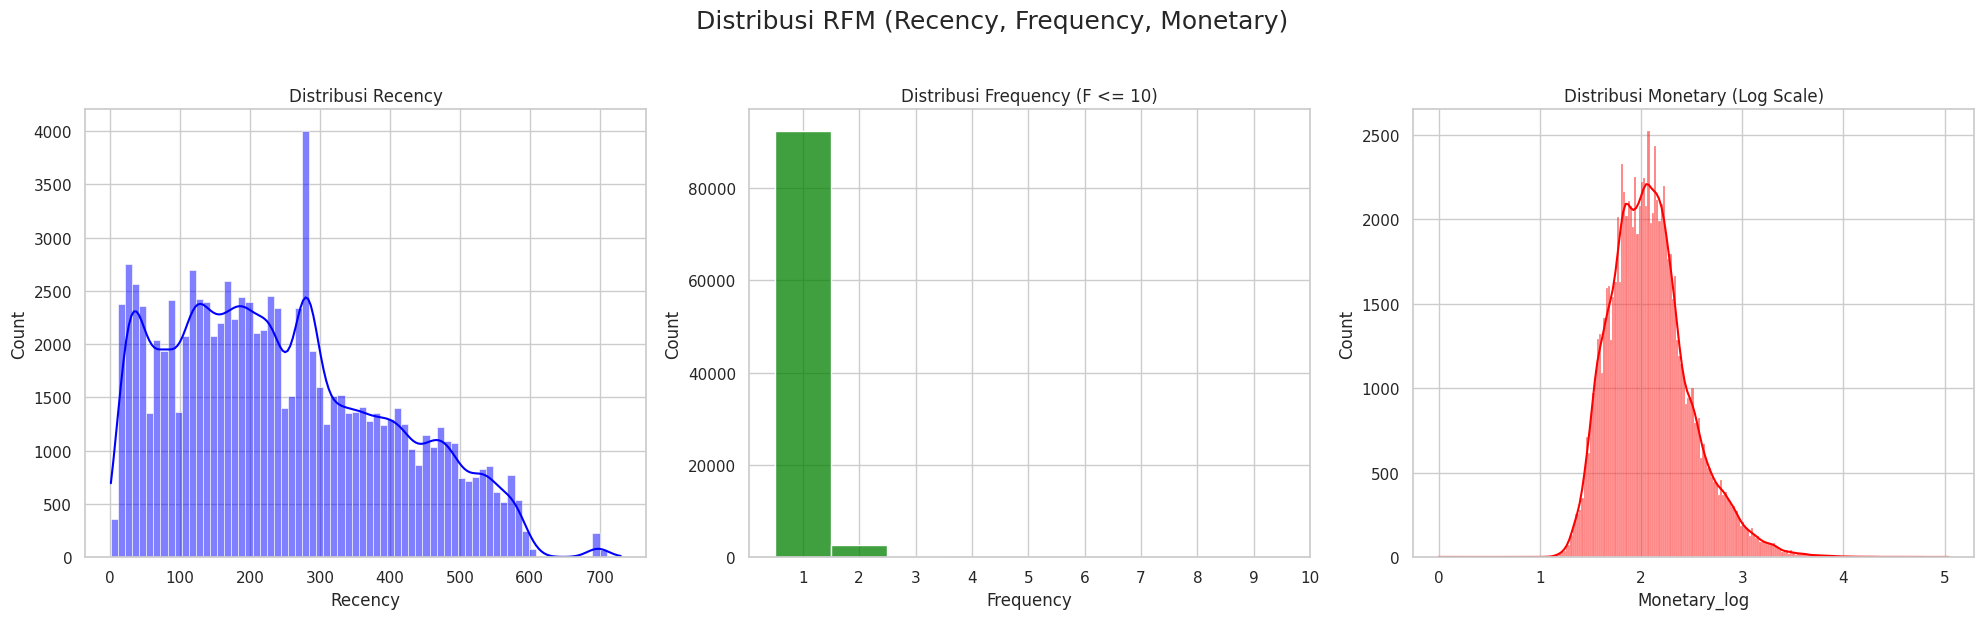


Semua visualisasi berhasil ditampilkan di atas.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nMemulai visualisasi di Colab...")
sns.set(style="whitegrid")

try:
    # --- 1. KPI: Tren Revenue Bulanan (Line Plot) ---
    print("Membuat plot 'Tren Revenue Bulanan'...")
    v_sales_report_df['full_date'] = pd.to_datetime(v_sales_report_df['full_date'])
    monthly_revenue = v_sales_report_df.set_index('full_date').resample('M')['payment_value'].sum().reset_index()

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=monthly_revenue, x='full_date', y='payment_value', marker='o')
    plt.title('Tren Revenue Bulanan (Monthly Revenue Trend)', fontsize=16)
    plt.xlabel('Bulan (Month)')
    plt.ylabel('Total Revenue (Payment Value)')
    plt.savefig('sales_trend_monthly.png') # Tetap simpan filenya
    plt.show() # <-- PERINTAH UNTUK MENAMPILKAN LANGSUNG

    # --- 2. Product Insights: Top 10 Kategori (Bar Plot) ---
    print("Membuat plot 'Top 10 Kategori Produk'...")
    top_categories = v_sales_report_df.groupby('product_category')['payment_value'].sum().nlargest(10).reset_index()

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_categories, y='product_category', x='payment_value', orient='h', palette='viridis')
    plt.title('Top 10 Kategori Produk (by Revenue)', fontsize=16)
    plt.xlabel('Total Revenue')
    plt.ylabel('Kategori Produk')
    plt.tight_layout()
    plt.savefig('top_10_categories.png')
    plt.show() # <-- TAMPILKAN LANGSUNG

    # --- 3. Geospatial Analysis: Top 10 Sales by State (Bar Plot) ---
    print("Membuat plot 'Top 10 Penjualan per Negara Bagian'...")
    sales_by_state = v_sales_report_df.groupby('customer_state')['payment_value'].sum().nlargest(10).reset_index()

    plt.figure(figsize=(12, 8))
    sns.barplot(data=sales_by_state, y='customer_state', x='payment_value', orient='h', palette='plasma')
    plt.title('Top 10 Penjualan per Negara Bagian (by Revenue)', fontsize=16)
    plt.xlabel('Total Revenue')
    plt.ylabel('Negara Bagian (State)')
    plt.tight_layout()
    plt.savefig('top_10_states.png')
    plt.show() # <-- TAMPILKAN LANGSUNG

    # --- 4. Customer Segmentation: Distribusi RFM (Histograms) ---
    print("Membuat plot 'Distribusi RFM'...")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    sns.histplot(rfm_analysis['Recency'], kde=True, ax=axes[0], color='blue')
    axes[0].set_title('Distribusi Recency')

    sns.histplot(rfm_analysis[rfm_analysis['Frequency'] <= 10]['Frequency'], kde=False, ax=axes[1], color='green', discrete=True)
    axes[1].set_title('Distribusi Frequency (F <= 10)')
    axes[1].set_xticks(range(1, 11))

    rfm_analysis['Monetary_log'] = np.log10(rfm_analysis['Monetary'] + 1)
    sns.histplot(rfm_analysis['Monetary_log'], kde=True, ax=axes[2], color='red')
    axes[2].set_title('Distribusi Monetary (Log Scale)')

    plt.suptitle('Distribusi RFM (Recency, Frequency, Monetary)', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.savefig('rfm_distributions.png')
    plt.show() # <-- TAMPILKAN LANGSUNG

    print("\nSemua visualisasi berhasil ditampilkan di atas.")

except NameError:
    print("\n!!! ERROR: DataFrame 'v_sales_report_df' atau 'rfm_analysis' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Sel 1 terlebih dahulu.")
except Exception as e:
    print(f"Terjadi error saat membuat visualisasi: {e}")